In [2]:
# -----------------------------
# Space Biology QA Pipeline
# -----------------------------

import os
import re
from dotenv import load_dotenv
from typing_extensions import List, TypedDict
from concurrent.futures import ThreadPoolExecutor, as_completed

from langchain import hub
from langchain_core.documents import Document
from langchain.chat_models import init_chat_model
from qdrant_client import QdrantClient
from langchain_mistralai import MistralAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from langgraph.graph import START, StateGraph

In [3]:
# -----------------------------
# Load environment variables
# -----------------------------
load_dotenv()
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

# -----------------------------
# Initialize Qdrant Client and Embeddings
# -----------------------------
# collection_name = "biology_articles_v3"
collection_name = "biology_articles"
client = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)

embeddings = MistralAIEmbeddings(model="mistral-embed")

store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings
)

# -----------------------------
# Load Prompts and LLM
# -----------------------------
prompt_research_old = hub.pull("pruebanasa/research_old")
llm = init_chat_model("open-mixtral-8x7b", model_provider="mistralai")

d:\proyectos_de_desarrollo\nasa\NASA_Nexus\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\proyectos_de_desarrollo\nasa\NASA_Nexus\venv\Lib\site-packages\pydantic\main.py:253: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [4]:
# -----------------------------
# Pipeline State
# -----------------------------
class State(TypedDict):
    question: str
    context: List[Document]
    summary: List[str]
    answer: str

# -----------------------------
# Document Retrieval
# -----------------------------
def retrieve_agent_scientists(state: dict, k=15) -> dict:
    """
    Recupera los top-k documentos más similares a la pregunta usando Qdrant
    y genera un resumen con título, fecha, link y contenido (chunk) de cada documento.
    """
    retrieved_docs = store.similarity_search(query=state["question"], k=k)

    if not retrieved_docs:
        print("[retrieve] No se encontraron documentos similares.")
        return {"context": [], "summary": "No se encontraron resultados."}

    resumen = []
    for i, doc in enumerate(retrieved_docs, start=1):
        meta = doc.metadata
        pmid = meta.get("pmid", "")
        pub_link = f"https://pubmed.ncbi.nlm.nih.gov/{pmid}/" if pmid else "N/A"

        info = f"""Document {i}
Title: {meta.get('title', 'Sin título')}
Date publication: {meta.get('publication_date', 'Desconocida')}
Authors: {meta.get('authors', 'Desconocida')}
Link: {pub_link}
Content:
{doc.page_content.strip()}
"""
        resumen.append(info)

    resumen_texto = "\n".join(resumen)
    print(f"[retrieve] Recuperados {len(retrieved_docs)} documentos")
    return {
        "context": retrieved_docs,
        "summary": resumen_texto
    }

# -----------------------------
# Generate final answer
# -----------------------------
def generate(state: State) -> State:
    """
    Genera la respuesta final basada en los documentos recuperados.
    """
    context = state.get("summary", [])

    # Preparar prompt para investigador
    messages = prompt_research_old.invoke({
        "question": state["question"],
        "context": context
    })

    response = llm.invoke(messages)
    answer = response.content.strip()

    state.update({
        "answer": answer,
    })
    return state

# -----------------------------
# Pipeline Construction
# -----------------------------
graph_builder = StateGraph(State).add_sequence([
    retrieve_agent_scientists,   # Recupera documentos relevantes
    generate    # Genera respuesta final
])

graph_builder.add_edge(START, "retrieve_agent_scientists")
graph = graph_builder.compile()

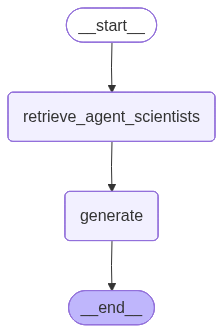

In [5]:
# -----------------------------
# Visualize pipeline (optional)
# -----------------------------
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# -----------------------------
# Example Queries
# -----------------------------
question_example_1 = "What are the main findings regarding plant growth in microgravity from NASA space biology experiments, and what patterns or trends can be identified across multiple studies?"
question_example_2 = "Based on the existing NASA space biology publications, what are the current gaps in knowledge about human immune system responses in space, and which areas could be prioritized for future experiments?"

response = graph.invoke({"question": question_example_1})
print("\nFinal Answer:")
print(response["answer"])

[retrieve] Recuperados 15 documentos

Final Answer:
**Summary of the current state of knowledge**

The documents provided discuss various aspects of plant growth and development in spaceflight conditions, focusing on altered gravity and microgravity effects. Plant seeds were first launched into space in 1946, and the first scientific experiment involving plant growth in space was carried out in 1971 [10, 11]. Since then, numerous studies have been conducted to understand the impact of spaceflight on plant biology, with many experiments performed in microgravity using ground-based facilities such as clinostats, random positioning machines (RPMs), drop towers, and parabolic flights [15, 18, 19]. The International Space Station (ISS) has significantly boosted space research, including plant growth experiments [13].

Previous studies have shown that microgravity impacts plant growth by altering the gravity vector, which affects developmental patterns [12, 26]. Roots are particularly sensit